In [1]:
% pylab inline
figsize(10, 8)

import sys
sys.path.append("/Users/humphreyshotton/ds/twicol")

Populating the interactive namespace from numpy and matplotlib


In [4]:
from pymongo import MongoClient
from Polygon import Polygon
from Polygon import Error as PolygonError

from geopy.distance import vincenty

# connect to mongodb
client = MongoClient("192.168.2", 27017)
db = client["twitter"]

# get the tweet cursor
cursor = db.geotweets.find({'locinf.mi.test': {'$ne': None}})

def get_poly(doc):
    # get the poly
    try:
        poly = eval(doc["locinf"]["mi"]["test"]["poly"])
    except KeyError:
        return None, None
        
    centres = []
    
    p = Polygon()
    for i in poly:
        p.addContour(i)

    try:
        center = p.center()
    except PolygonError:
        return None, None
    
    return p, center

uname = []
infos = []
totalcount = 0
count = 0
nocount = 0

for doc in cursor:
    totalcount += 1
    if doc["geo"] is None:
        continue

    # get the real point
    point = (doc["geo"]["coordinates"][1], doc["geo"]["coordinates"][0])
    # get the poly and the centre
    poly, center = get_poly(doc)
    
    if poly is None:
        nocount += 1
        continue

    distance = vincenty((point[1], point[0]), (center[1], center[0])).km
    
    info = [
        distance,
        poly.area(),
        doc["locinf"]["mi"]["test"]["weight"],
        doc["locinf"]["mi"]["test"]["len"]["polys"],
        doc["locinf"]["mi"]["test"]["len"]["inds"],   
    ]
    uname.append(doc["user"]["screen_name"])
    infos.append(info)
    
    count += 1
    if count % 1000 == 0:
        print("Processed", count)


Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000
Processed 12000
Processed 13000
Processed 14000
Processed 15000
Processed 16000
Processed 17000
Processed 18000
Processed 19000
Processed 20000
Processed 21000
Processed 22000
Processed 23000
Processed 24000
Processed 25000
Processed 26000
Processed 27000
Processed 28000
Processed 29000
Processed 30000
Processed 31000
Processed 32000
Processed 33000
Processed 34000
Processed 35000
Processed 36000
Processed 37000
Processed 38000
Processed 39000
Processed 40000
Processed 41000
Processed 42000
Processed 43000
Processed 44000
Processed 45000
Processed 46000
Processed 47000
Processed 48000
Processed 49000


In [11]:
X = asarray(infos)
X[0]

array([  4.94879503e+03,   3.69274187e+00,   2.38272793e+00,
         6.00000000e+00,   3.00000000e+00])

In [14]:
def func(x, w):
    return sum([x[i+1] * w[i] for i in range(len(w))])
                
def err(x, w):
    return func(x, w) - x[0]

def opt(w):
    return sum([err(x, w) for x in X])   

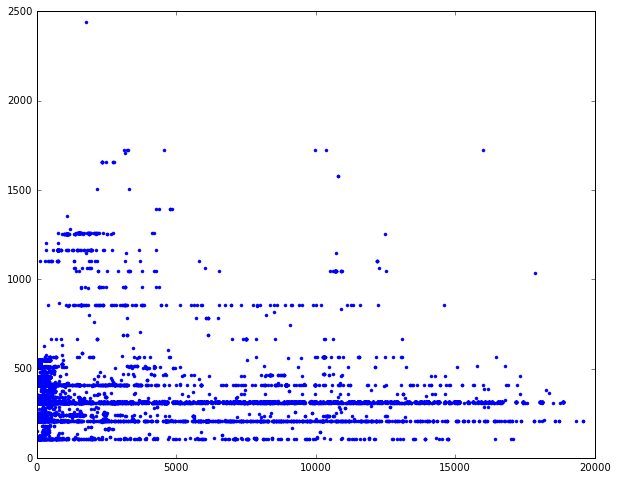

In [28]:
w = [1, 1, 1, 100]
plot(X[:,0], [func(x, w) for x in X], 'b.')

In [20]:
import scipy.optimize
   
# use the optimize function
xopt = scipy.optimize.fmin(func=opt, x0=[1, 1, 1, 1])
print("Weights:", xopt)

Weights: [ -2.65416005e+50   7.74431616e+48   1.22410502e+49   1.20851611e+50]


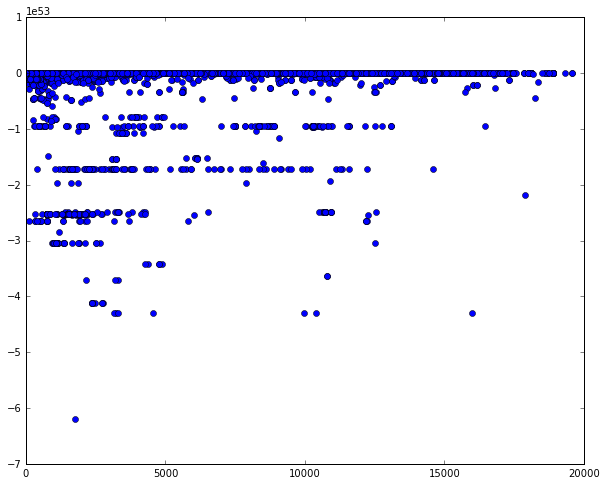

In [22]:
wo = [ -2.65416005e+50, 7.74431616e+48,  1.22410502e+49, 1.20851611e+50]
plot(X[:,0], [func(x, wo) for x in X], 'bo')